In [1]:
# Common imports
import csv
import os
import sys
# Scikit-Learn ≥0.20
import sklearn
# numpy matplotlib
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
with open('./bank_marketing_data/bank.data.norm') as csv_file:
    bank_data_norm = np.loadtxt(csv_file, delimiter=",")

print("bank_data_norm shape, dtype = ",
      bank_data_norm.shape,
      bank_data_norm.dtype
)

bank_data_norm shape, dtype =  (4521, 17) float64


In [3]:
# Sanity check for X and y extraction
first_row = np.array([
    0.161777,0.090992,0.500250,0.333555,
    1.000000,0.068455,1.000000,1.000000,
    0.500250,0.600013,0.818198,0.024827,
    0.000020,0.000001,0.000040,0.000333,
    1.000000
])


# extract the first 16 columns as features X
X = bank_data_norm[:, :-1]
print("X.shape, X.dtype = ", X.shape, X.dtype)
print("X[0] = ", X[0])
np.testing.assert_array_equal(X[0], first_row[:-1])


# extract the last column as label y
y = bank_data_norm[:, -1:].astype(np.int)
np.testing.assert_array_equal(y[0], first_row[-1:])
# a 1d array was expected. Please change the shape of y to (n_samples, )
y = y.ravel()
print("y.shape, y[:5], y.dtype = ", y.shape, y[:5], y.dtype)
print("=== X and y extraction done ===")

X.shape, X.dtype =  (4521, 16) float64
X[0] =  [1.61777e-01 9.09920e-02 5.00250e-01 3.33555e-01 1.00000e+00 6.84550e-02
 1.00000e+00 1.00000e+00 5.00250e-01 6.00013e-01 8.18198e-01 2.48270e-02
 2.00000e-05 1.00000e-06 4.00000e-05 3.33000e-04]
y.shape, y[:5], y.dtype =  (4521,) [1 1 1 1 1] int64
=== X and y extraction done ===


In [4]:
# reproduce the seed 42 shuffle used by FL engine
with open('./bank_marketing_data/falcon_client0_data_indexes_str_Seed42.txt') as csv_file:
     seed_42_indices = np.loadtxt(csv_file, delimiter=",").astype(np.int)

print("seed 42's indices: ", seed_42_indices)
print("seed_42_indices.shape, seed_42_indices.dtype = ", seed_42_indices.shape, seed_42_indices.dtype)

# split_percentage = 0.8
# 4521 * .8 = 3616.8
# The training data consists of 3616 rows, while the testing data consists of 905 rows.

print("seed_42_indices[3614:3618] = ", seed_42_indices[3614:3618])

train_indices = seed_42_indices[:3616]
test_indices = seed_42_indices[3616:]
print("train_indices.shape, test_indices.shape = ", train_indices.shape, test_indices.shape)
print("train_indices[-2:], test_indices[:2] = ", train_indices[-2:], test_indices[:2])

seed 42's indices:  [2189 2105 1870 ... 4275 2539 3936]
seed_42_indices.shape, seed_42_indices.dtype =  (4521,) int64
seed_42_indices[3614:3618] =  [1300 1741 2816 4245]
train_indices.shape, test_indices.shape =  (3616,) (905,)
train_indices[-2:], test_indices[:2] =  [1300 1741] [2816 4245]


In [5]:
# Reconstruct the train and test data

# empty array with proper dimensionality.
X_train = np.empty((0, 16))
X_test = np.empty((0, 16))
y_train = np.empty((0))
y_test = np.empty((0))


for index in train_indices:
    X_train = np.vstack((X_train, X[index]))
    y_train = np.append(y_train, y[index])
    
for index in test_indices:
    X_test = np.vstack((X_test, X[index]))
    y_test = np.append(y_test, y[index])

print("X_train.dtype, X_train.shape = ", X_train.dtype, X_train.shape)
print("X_test.dtype, X_test.shape = ", X_test.dtype, X_test.shape)
print("y_train.dtype, y_train.shape = ", y_train.dtype, y_train.shape)
print("y_test.dtype, y_test.shape = ", y_test.dtype, y_test.shape)


# Sanity check for split train test
row_2189 = np.array([
    0.352951,0.363694,0.500250,0.333555,
    1.000000,0.054912,0.000999,0.000999,
    0.000500,0.466684,0.363694,0.092685,
    0.081651,0.000001,0.000040,0.000333,
    1.000000
])
row_3936 = np.array([
    0.220600,0.272793,0.500250,1.000000,
    1.000000,0.085408,0.000999,1.000000,
    0.500250,0.400020,0.363694,0.153923,
    0.000020,0.000001,0.000040,0.000333,
    0.000000
])

np.testing.assert_array_equal(X_train[0], row_2189[:-1])
np.testing.assert_array_equal(X_test[-1], row_3936[:-1])
np.testing.assert_array_equal(y_train[0], row_2189[-1:])
np.testing.assert_array_equal(y_test[-1], row_3936[-1:])
print("=== split train test done ===")

X_train.dtype, X_train.shape =  float64 (3616, 16)
X_test.dtype, X_test.shape =  float64 (905, 16)
y_train.dtype, y_train.shape =  float64 (3616,)
y_test.dtype, y_test.shape =  float64 (905,)
=== split train test done ===


In [6]:
# Assert and Test that Positive and Negative Class Count Match
# for train split --> 406 3210 
np.testing.assert_equal(np.count_nonzero(y_train == 1), 3210)
np.testing.assert_equal(np.count_nonzero(y_train == 0), 406)
# for test split --> 115 790
np.testing.assert_equal(np.count_nonzero(y_test == 1), 790)
np.testing.assert_equal(np.count_nonzero(y_test == 0), 115)
print("=== y_train y_test count matches ===")

=== y_train y_test count matches ===


## Logistic Regression Classifier with sklearn

In [7]:
# run logistic regress from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.metrics import log_loss

# train a Logistic Regression model
clf = LogisticRegression(
    random_state=42,
    verbose=10,
    penalty='none',  # If ‘none’, no regularization is applied.
    max_iter=50,
)
clf.fit(X_train, y_train)

loss = log_loss(y_test, clf.predict_proba(X_test), eps=1e-15)
print("test set loss = ", loss)

test set loss =  0.2916087602205399


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/svd/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


clf.classes_ =  [0. 1.]
x_test's first 3 predicted probabilities = 
 [[0.10668627 0.89331373]
 [0.05692859 0.94307141]
 [0.02335335 0.97664665]]
cm =
 [[ 23  92]
 [ 10 780]]
              precision    recall  f1-score   support

   Class Yes       0.70      0.20      0.31       115
    Class No       0.89      0.99      0.94       790

    accuracy                           0.89       905
   macro avg       0.80      0.59      0.62       905
weighted avg       0.87      0.89      0.86       905



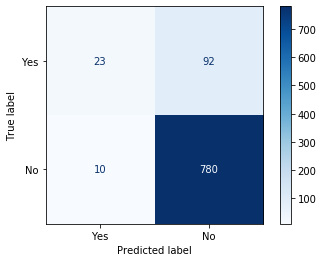

In [8]:
# show the classes
print("clf.classes_ = ", clf.classes_)

# The first column is the probability of the predicted output being zero, that is 1 - 𝑝(𝑥)
# The second column is the probability that the output is one, or 𝑝(𝑥).
print("x_test's first 3 predicted probabilities = \n", clf.predict_proba(X_test)[:3])

# get actual predicted class
y_pred = clf.predict(X_test)

# show the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("cm =\n", cm)
plot_confusion_matrix(
    clf, X_test, y_test,
    display_labels=['Yes', 'No'],
    cmap=plt.cm.Blues,
)
target_names = ['Class Yes', 'Class No']
print(classification_report(y_test, y_pred, target_names=target_names))

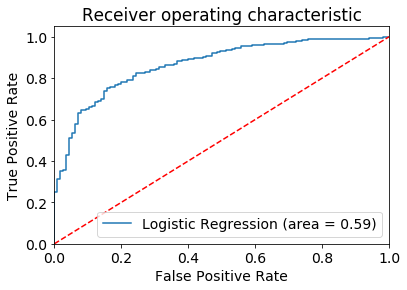

In [9]:
# code taken from tutorial:
# https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt 
plt.rc("font", size=14)

logit_roc_auc = roc_auc_score(y_test, clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
# print("thresholds = ", thresholds)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
plt.show()

0.8668794716565769


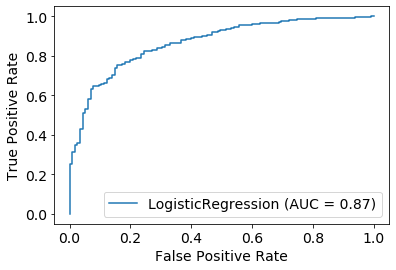

In [10]:
import matplotlib.pyplot as plt 
from sklearn import metrics
from sklearn.metrics import roc_auc_score

print(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
metrics.plot_roc_curve(clf, X_test, y_test)  
plt.show() 

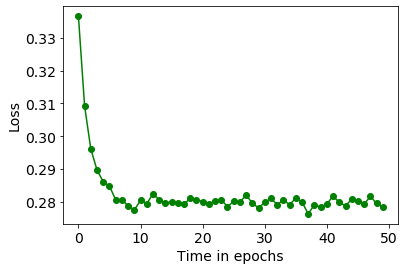

In [11]:
from io import StringIO
from sklearn.linear_model import SGDClassifier


# from stackoverflow answer:
# https://stackoverflow.com/questions/44443479/python-sklearn-show-loss-values-during-training
# NOTE: only works for SGDClassifier, not for LogisticRegression
# but the loss values should be similar
old_stdout = sys.stdout
sys.stdout = mystdout = StringIO()
clf = SGDClassifier(
    loss='log',  #‘log’ loss gives logistic regression
    penalty='none',
    verbose=10,
    max_iter=50,
    learning_rate='constant',
    eta0=0.1,  # initial learning rate for the ‘constant’
    tol=None,  # do not early stop
)
clf.fit(X_train, y_train)

sys.stdout = old_stdout
loss_history = mystdout.getvalue()
loss_list = []
for line in loss_history.split('\n'):
    if(len(line.split("loss: ")) == 1):
        continue
    loss_list.append(float(line.split("loss: ")[-1]))
# print(loss_list)
# mystdout.flush()
plt.figure()
plt.plot(np.arange(len(loss_list)), loss_list, 'go-')
# plt.savefig("warmstart_plots/pure_SGD.png")
plt.xlabel("Time in epochs")
plt.ylabel("Loss")
plt.show()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


=============== Loss Array ===============
[]
=============== Loss Array ===============
[0.34113  0.308165 0.294514 0.286732 0.281676 0.282337 0.279866 0.282106
 0.280627 0.28047  0.278102 0.279001 0.278575 0.280896 0.280078 0.278088
 0.279206 0.280565 0.280297 0.281276 0.28126  0.281831 0.282169 0.279445
 0.279848 0.27685  0.278248 0.280443 0.280338 0.282584 0.279578 0.279863
 0.281017 0.278601 0.278352 0.280589 0.278782 0.27969  0.280693 0.277503
 0.278644 0.280423 0.278407 0.279553 0.279169 0.280698 0.279222 0.279651
 0.27869  0.280604]


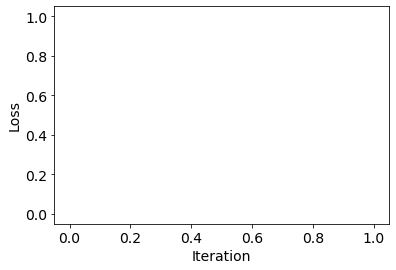

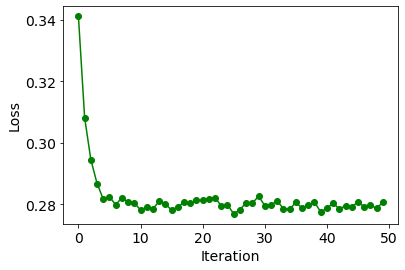

In [12]:
# adapted and updated the answer from @OneRaynyDay
# from https://stackoverflow.com/questions/44443479/python-sklearn-show-loss-values-during-training

import sys
import io
import matplotlib.pyplot as plt

class DisplayLossCurve(object):
    def __init__(self, print_loss=True):
        self.print_loss = print_loss

    """Make sure the model verbose is set to 1"""
    def __enter__(self):
        self.old_stdout = sys.stdout
        sys.stdout = self.mystdout = io.StringIO()
  
    def __exit__(self, *args, **kwargs):
        sys.stdout = self.old_stdout
        loss_history = self.mystdout.getvalue()
        loss_list = []
        for line in loss_history.split('\n'):
            if(len(line.split("loss: ")) == 1):
                continue
            loss_list.append(float(line.split("loss: ")[-1]))
        plt.figure()
        plt.plot(np.arange(len(loss_list)), loss_list, 'go-')
        plt.xlabel("Iteration")
        plt.ylabel("Loss")

        if self.print_loss:
            print("=============== Loss Array ===============")
            print(np.array(loss_list))
      
        return True


from sklearn.linear_model import SGDRegressor

model = SGDRegressor(verbose=1)

# train a Logistic Regression model
clf = LogisticRegression(
    random_state=42,
    verbose=10,
)


with DisplayLossCurve(print_loss=True):
    clf.fit(X_train, y_train)


# NOTE: only works for SGDClassifier, not for LogisticRegression
# but the loss values should be similar
clf = SGDClassifier(
    loss='log',  #‘log’ loss gives logistic regression
    penalty='none',
    verbose=10,
    max_iter=50,
    learning_rate='constant',
    eta0=0.1,  # initial learning rate for the ‘constant’
    tol=None,  # do not early stop
)

with DisplayLossCurve(print_loss=True):
    clf.fit(X_train, y_train)